# A simple `klausen` model

The `klausen` package provides an easy way to write stochastic models in Python using named parameters. The lifecycle of a `klausen` calculation has three steps:

* The modeller defines a set of (quasi-)independent input parameters in a `klausen.NamedParameters` instance. The uncertainty of these parameters can be defined by probability distribution functions (defined using [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/), or by providing a population data sample.
* The input parameters are provided to a Python model, which is executed. The model should be ready to accept each parameter as a one-dimensional Numpy array.
* The model outputs are then directly analyzed, or exported to serve as inputs for other calculations (e.g. life cycle assessment using [Brightway](https://brightwaylca.org/).

## First step: Input parameters

In this simple example, we will examine the behaviour of a motor scooter. We will define two input parameters - standard fuel consumption (kg / km), and the behaviour of the driver (unitless). Fuel consumption will follow the Gaussian distribution, with a mean of 10 grams of gasoline per kilometer, a standard deviation of 3, and a minimum of 5. We assume that driver behaviour is a multiplier of fuel consumption, and follows a triangular distribution from 0.8 (minimum) to 1 (mode) to 1.2 (maximum).

In [36]:
import klausen
import presamples
import stats_arrays as sa
import numpy

In [53]:
parameters = {
    'fuel_consumption': {
        'loc': 0.01,
        'scale': 0.003,
        'minimum': 0.005,
        'uncertainty_type': sa.NormalUncertainty.id
    },
    'driver': {
        'uncertainty_type': sa.TriangularUncertainty.id,
        'minimum': 0.8,
        'loc': 1,
        'maximum': 1.2
    }
}
np = klausen.NamedParameters(parameters)

We want to do Monte Carlo analysis, so we tell the `NamedParameters` object to generate samples.

In [54]:
np.stochastic(iterations=1000)

## Second step: Model

As our example is quite simple, the model can also be quite simple.

In the model, we assume that complete combustion of one kilogram of gasoline produces three kilograms of $CO_{2}$. This could also have been an uncertain parameter specified in step one.

In [55]:
def scooter_model(np):
    actual_fuel_consumption = np['fuel_consumption'] * np['driver']
    co2 = 3 * actual_fuel_consumption
    return numpy.vstack((
        numpy.array(actual_fuel_consumption), 
        numpy.array(co2)
    ))

In [56]:
results = scooter_model(np)

## Third step: Interpretation or reuse

In this case, we will import the results into Brightway and link against ecoinvent.

We will use the [presamples package](https://github.com/PascalLesage/brightway2-presamples) to substitute in our numbers during Monte Carlo *and* during static LCA. We start by defining the values to be used during Monte Carlo.

We already have the values for $CO_{2}$ and fuel consumption, but we still need to know which *exchanges* in ecoinvent to change. There are better ways to do this with a lot of output parameters, but in our case we can just find the ones we want directly.

In [57]:
import brightway2 as bw

In [58]:
assert "ecoinvent 3.5 cutoff" in bw.databases

In [59]:
co2 = next(x for x in bw.Database("biosphere3") 
           if x['name'] == 'Carbon dioxide, fossil' 
           and x['categories'] == ('air',)).key
scooter = next(x for x in bw.Database("ecoinvent 3.5 cutoff")
               if x['name'] == 'transport, passenger, motor scooter'
               and x['location'] == 'CH').key
petrol = next(x for x in bw.Database("ecoinvent 3.5 cutoff")
                if x['name'] == 'market for petrol, low-sulfur'
                and x['location'] == 'RoW').key

In [60]:
_, stochastic_filepath = presamples.create_presamples_package(
    matrix_data=[
        (
            results[0, :].reshape((1, -1)), 
            [(petrol, scooter, 'technosphere')], 
            'technosphere',
        ), (
            results[1, :].reshape((1, -1)), 
            [(co2, scooter, 'biosphere')], 
            'biosphere'
        ),
    ], 
    name='Simple Klausen example'
)

In [61]:
np.static()

In [62]:
results = scooter_model(np).reshape((-1, 1))

In [63]:
_, static_filepath = presamples.create_presamples_package(
    matrix_data=[
        (
            results[0, :].reshape((1, -1)), 
            [(petrol, scooter, 'technosphere')], 
            'technosphere',
        ), (
            results[1, :].reshape((1, -1)), 
            [(co2, scooter, 'biosphere')], 
            'biosphere'
        ),
    ], 
    name='Simple Klausen example'
)

In [64]:
IPCC = ('IPCC 2013', 'climate change', 'GWP 100a')

In [65]:
lca = bw.LCA({scooter: 1}, IPCC)
lca.lci()
lca.lcia()
lca.score

0.1436845381180854

In [66]:
lca = bw.LCA({scooter: 1}, IPCC, presamples=[static_filepath])
lca.lci()
lca.lcia()
lca.score

0.10989319351698595

In [67]:
mc = bw.MonteCarloLCA({scooter: 1}, IPCC, presamples=[stochastic_filepath])
mc_results = numpy.array([next(mc) for _ in range(500)])

/Users/cmutel/Code/presamples/presamples/loader.py:257: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  ] = sample


In [68]:
%matplotlib inline

In [69]:
import seaborn as sb

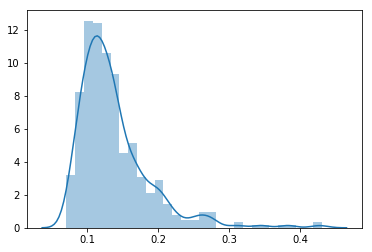

In [70]:
sb.distplot(mc_results)